## Data Import from Kaggle

In [1]:
#In Colab, you need to install the Kaggle library.
!pip install -q kaggle;

In [2]:
!pip install timm; # library with a collection of image  models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00


In [3]:
# json token file
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [4]:
#Move the uploaded kaggle.json file to the appropriate directory.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#list of datasets with the word alzheimers
!kaggle datasets list -s alzheimers

ref                                                   title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
jboysen/mri-and-alzheimers                            MRI and Alzheimers                             13KB  2017-08-16 17:18:10          26879        480  0.85294116       
tourist55/alzheimers-dataset-4-class-of-images        Alzheimer's Dataset ( 4 class of Images)       34MB  2019-12-26 19:02:53          26432        434  0.75             
madhucharan/alzheimersdisease5classdatasetadni        Alzheimers-Disease-5-Class-Dataset-ADNI        17MB  2021-02-16 04:14:15           3352         38  0.4375           
sachinkumar413/alzheimer-mri-dataset                  Alzheimer MRI Preprocessed Dataset             28MB  2022-03-27 05:25:19           910

In [6]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 97% 33.0M/34.1M [00:00<00:00, 78.4MB/s]
100% 34.1M/34.1M [00:00<00:00, 67.2MB/s]


In [ ]:
! mkdir Omdena
! unzip alzheimers-dataset-4-class-of-images.zip -d Omdena/

In [8]:
# Import libraries
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

## Model Training

### Data Preprocessing

In [ ]:
# Define path to the training data directory
train_dir = "/content/Omdena/Alzheimer_s Dataset/train"

# Define image generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Create a training data flow
train_unbalanced = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 5121 images belonging to 4 classes.


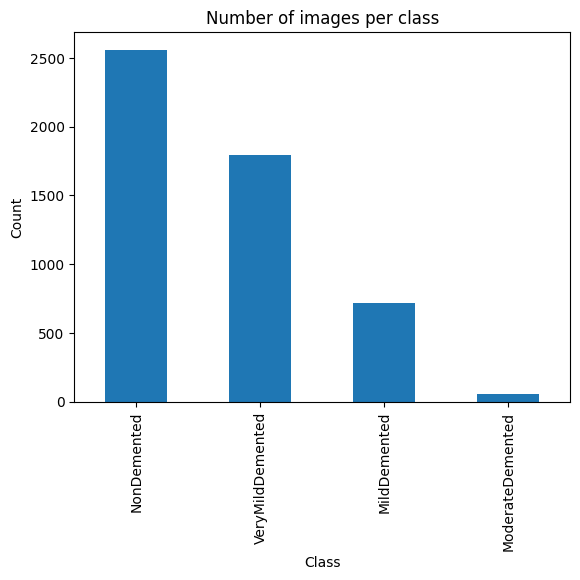

In [ ]:
# Get list of all classes
classes = os.listdir(train_dir)

# Count number of images per class
counts = {}
for class_name in classes:
    counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])

# Create bar plot
df_counts.sort_values('count', ascending=False).plot(kind='bar', legend=False)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### CNN Model

In [ ]:
# Define your CNN model
model = keras.Sequential([
    # Add convolutional layers, pooling layers, activation functions
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=4, activation="softmax")
])

# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# Train the model
model.fit(train_unbalanced, epochs=10)

In [ ]:
# Assume 'model' is your trained model
model.save('unbalanced.h5')  # Creates a HDF5 file 'my_model.h5'

In [ ]:
# Define path to the test data directory
test_dir = "/content/Omdena/Alzheimer_s Dataset/test"

# Define a test image generator
test_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Create a test data flow
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluate the model on the test set
result = model.evaluate(test_generator)

# Access the loss and accuracy values
loss = result[0]
accuracy = result[1]

# Print the evaluation results
print(f"Loss: {loss}, Accuracy: {accuracy}")

40/40 [==============================] - 56s 1s/step - loss: 1.2538 - accuracy: 0.5168
Loss: 1.253812551498413, Accuracy: 0.5168099999427795


In [ ]:
# Convert loss and accuracy to percentages
loss_percent = loss * 100
accuracy_percent = accuracy * 100

# Print the evaluation results in percentage format
print(f"Loss: {loss_percent:.2f}%, Accuracy: {accuracy_percent:.2f}%")

Loss: 125.38%, Accuracy: 51.68%


### Metrics

1279/1279 [==============================] - 67s 52ms/step
Accuracy: 0.52
                  precision    recall  f1-score   support

     NonDemented       0.52      0.48      0.50       179
VeryMildDemented       1.00      0.25      0.40        12
    MildDemented       0.72      0.38      0.50       640
ModerateDemented       0.44      0.76      0.56       448

        accuracy                           0.52      1279
       macro avg       0.67      0.47      0.49      1279
    weighted avg       0.60      0.52      0.52      1279



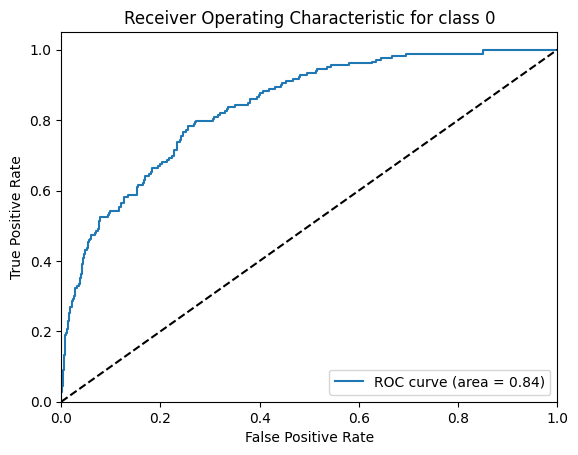

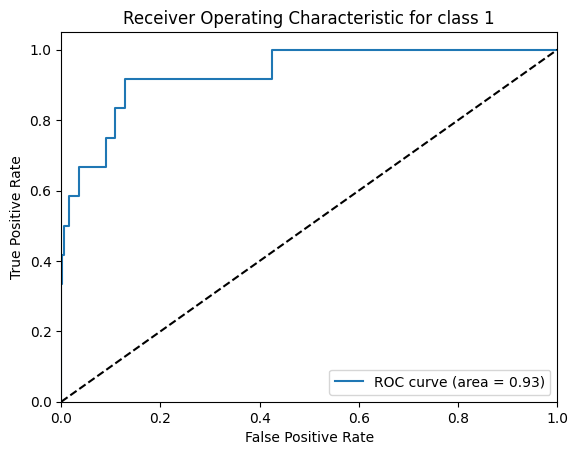

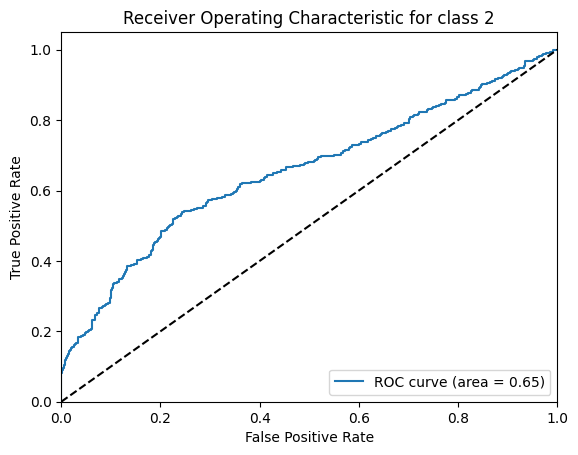

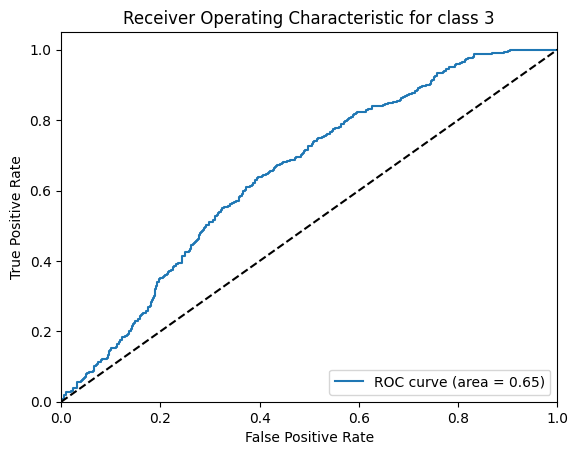

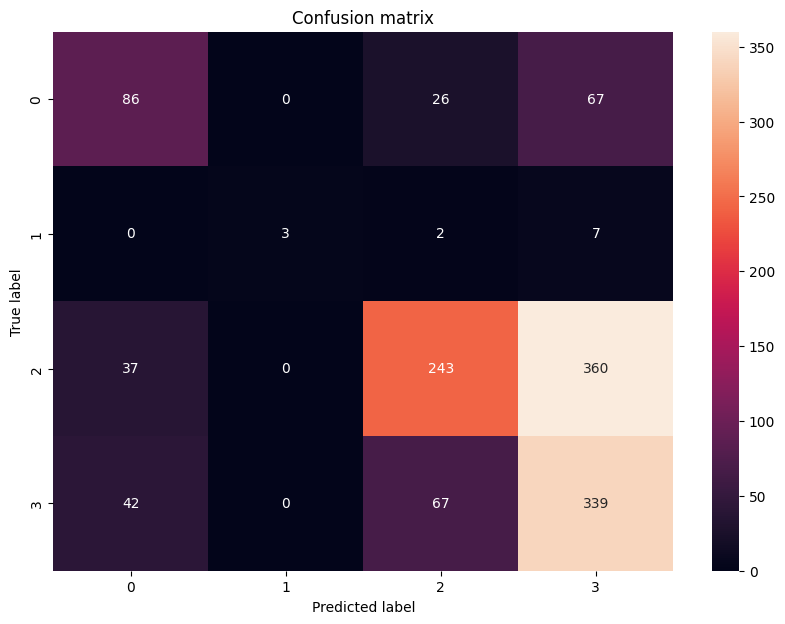

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_score = model.predict(test_generator, steps=len(test_generator.filenames))

# Binarize the output
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 4
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_class_{}.png'.format(i))  # Saves the ROC curve for class i

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_score, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_matrix.png')  # Saves the confusion matrix

# Compute accuracy
accuracy = accuracy_score(y_true, np.argmax(y_score, axis=1))
print('Accuracy: {:.2f}'.format(accuracy))

# Compute sensitivity (recall) and F1 score for each class
report = classification_report(y_true, np.argmax(y_score, axis=1), target_names=classes)
print(report)
